In [1]:
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from bokeh.charts import Histogram, output_file, show
from bokeh.plotting import output_notebook

%matplotlib inline
%autosave 30
output_notebook()

Autosaving every 30 seconds


Loading BokehJS ...

In [2]:
sample_code_dic = {"01": "Primary Solid Tumor",
                   "11": "Solid Tissue Normal",
                   "02": "Recurrent Solid Tumor",
                   "06": "Metastatic",
                   "07": "Additional Metastatic",
                   "05": "Additional - New Primary",
                   "03": "Primary Blood Derived Cancer - Peripheral Blood"}

In [8]:
df = pd.read_csv("data/RNASeq_barcodes.txt", delimiter="\t")
sample_codes=list(i.split("-")[3][:-1] for i in df.sample_barcode)
stats = {sample_code_dic[x]:sample_codes.count(x) for x in sample_codes}

In [9]:
stats

{'Additional - New Primary': 11,
 'Additional Metastatic': 1,
 'Metastatic': 395,
 'Primary Blood Derived Cancer - Peripheral Blood': 173,
 'Primary Solid Tumor': 9706,
 'Recurrent Solid Tumor': 46,
 'Solid Tissue Normal': 737}

In [73]:
tumor_barcodes = [i for i in df.sample_barcode if i.split("-")[3][:-1]=="01"]
normal_barcodes = [i for i in df.sample_barcode if i.split("-")[3][:-1]=="11"]
tumor_persons = set([i.split("-")[2] for i in tumor_barcodes])
normal_persons = set([i.split("-")[2] for i in normal_barcodes])
overlap = normal_persons.intersection(tumor_persons)
overlap_barcodes = [i for i in df.sample_barcode if 
                    (i.split("-")[2] in overlap and i.split("-")[3][:-1] in ["01", "11"])]

In [56]:
pickle.dump(overlap, open("data/matched_tumor_normal_patients.pkl", "wb"))

In [63]:
mRNA = pd.read_csv("data/RNASeq_transposed.tsv", delimiter="\t")

In [138]:
tumor_normal_df = mRNA[mRNA.sample_barcode.isin(overlap_barcodes)].copy()
tumor_normal_df["label"] = [1 if i.split("-")[3][:-1] == "11" else 0 
                            for i in tumor_normal_df.sample_barcode]
tumor_normal_df["patient_id"] = [i.split("-")[2] 
                                 for i in tumor_normal_df.sample_barcode]
final_df = tumor_normal_df.dropna(axis=1)

In [98]:
final_df.to_csv("data/RNASeq_tumor_v_normal.tsv", sep="\t", index=None)

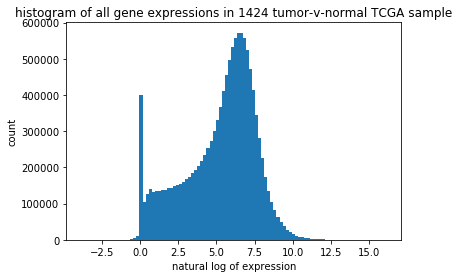

In [183]:
# gene expression histogram
final_df.reset_index(inplace=True, drop=True)
gene_columns = final_df.columns[1:-2]
log_expression = list(map(lambda x: np.log(x+1), final_df[gene_columns].as_matrix().flatten()))
plt.hist(log_exp, bins=100)
plt.xlabel("natural log of expression")
plt.ylabel("count")
plt.title("histogram of all gene expressions in 1424 tumor-v-normal TCGA sample")
plt.show()

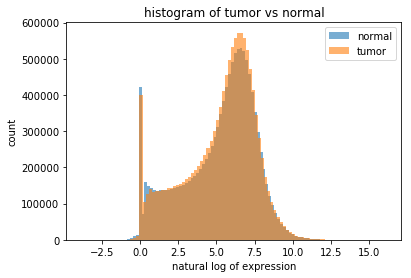

In [186]:
for sample in [0,1]:
    sample_df = final_df[final_df.label == sample].copy()
    log_exp = list(map(lambda x: np.log(x+1), sample_df[gene_columns].as_matrix().flatten()))
    plt.hist(log_exp, bins=100, alpha=0.6)
plt.xlabel("natural log of expression")
plt.ylabel("count")
plt.title("histogram of tumor vs normal")
plt.legend(["normal", "tumor"])
plt.show()

In [10]:
# log transformation of mRNA data
df = pd.read_csv("data/RNASeq_tumor_v_normal.tsv", delimiter="\t", low_memory=False)
gene_columns = df.columns[1:-2]
df[gene_columns] = df[gene_columns].apply(lambda x: np.log(x+1), axis=1).copy()
df.to_csv("data/RNASeq_tumor-v-normal_log_transform.tsv", index=None, sep="\t")

### explore differentially expressed genes

In [12]:
df = pd.read_csv("data/RNASeq_tumor-v-normal_log_transform.tsv", delimiter="\t", low_memory=False)
gene_columns = df.columns[1:-2]
tumor_df = df[df.label==1].copy().sort_values(by="patient_id")
normal_df = df[df.label==0].copy().sort_values(by="patient_id")
assert(list(tumor_df.patient_id) == list(normal_df.patient_id))
assert(list(tumor_df.columns) == list(normal_df.columns))
diff = tumor_df[gene_columns].values - normal_df[gene_columns].values
sample_expression = np.random.choice(diff.flatten(), size=10000)
p = Histogram(sample_expression, xlabel="tumor-normal mRNA expression", plot_height=400)
show(p)

In [16]:
# save difference data
diff_df = pd.DataFrame(data=diff, columns=gene_columns)
diff_df["id"] = normal_df["patient_id"]
diff_df.to_csv("data/RNASeq_tumor_normal_log_diff_log.tsv", sep="\t", index=None)